In [ ]:
# pip install seaborn

In [ ]:
# pip install statsmodels

In [ ]:
# pip install openpyxl

In [615]:
import pandas as pd
import numpy as np
from datetime import timedelta, date
import pytz
import time
import itertools

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdate

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [545]:
test = pd.read_csv('/Users/marie-noellepage/Documents/Formation/McGill/2. Applied Artificial Intelligence/4. Time Series Analysis Fundamentals/Course 4/Assignment_test.csv')
train = pd.read_csv('/Users/marie-noellepage/Documents/Formation/McGill/2. Applied Artificial Intelligence/4. Time Series Analysis Fundamentals/Course 4/Assignment_train.csv')

In [432]:
train.tail()

,Unnamed: 0,Month,Day,Hour,MWh
7290,7290,10.0,31.0,20.0,34.72
7291,7291,10.0,31.0,21.0,30.53
7292,7292,10.0,31.0,22.0,29.22
7293,7293,10.0,31.0,23.0,26.99
7294,7294,10.0,31.0,24.0,22.08


In [433]:
test.head()

,Unnamed: 0,Month,Day,Hour,MWh
0,7295,11.0,1.0,1.0,13.03
1,7296,11.0,1.0,2.0,12.82
2,7297,11.0,1.0,3.0,12.82
3,7298,11.0,1.0,4.0,12.58
4,7299,11.0,1.0,5.0,12.49


In [546]:
dft = pd.concat([train, test], axis=0)

# Preprocessing

In [437]:
dft.describe()
# Month with 0 ...

,Unnamed: 0,Month,Day,Hour,MWh
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,4379.500000,6.526598,15.719749,12.499886,31.360779
std,2528.938512,3.448673,8.797587,6.922763,13.451076
min,0.000000,0.000000,1.000000,1.000000,5.910000
25%,2189.750000,4.000000,8.000000,6.750000,23.857500
50%,4379.500000,7.000000,16.000000,12.500000,29.770000
75%,6569.250000,10.000000,23.000000,18.250000,36.160000
max,8759.000000,12.000000,31.000000,24.000000,188.800000


In [438]:
print(dft[dft['Month']==0])

      Unnamed: 0  Month   Day  Hour    MWh
1658        1658    0.0  11.0   4.0  21.12


In [439]:
print(dft[dft['Unnamed: 0']>=1656].head())

      Unnamed: 0  Month   Day  Hour    MWh
1656        1656    3.0  11.0   2.0  21.57
1657        1657    3.0  11.0   3.0  21.10
1658        1658    0.0  11.0   4.0  21.12
1659        1659    3.0  11.0   5.0  21.38
1660        1660    3.0  11.0   6.0  23.71


In [547]:
# Fixed with 3 (March)
dft['Month'].replace(to_replace = 0, value = 3, inplace=True)

In [441]:
dft.describe()

,Unnamed: 0,Month,Day,Hour,MWh
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,4379.500000,6.526941,15.719749,12.499886,31.360779
std,2528.938512,3.448174,8.797587,6.922763,13.451076
min,0.000000,1.000000,1.000000,1.000000,5.910000
25%,2189.750000,4.000000,8.000000,6.750000,23.857500
50%,4379.500000,7.000000,16.000000,12.500000,29.770000
75%,6569.250000,10.000000,23.000000,18.250000,36.160000
max,8759.000000,12.000000,31.000000,24.000000,188.800000


I found the dataset on Hydro-Quebec website (year = 2019): 
https://www.hydroquebec.com/documents-data/open-data/history-generation-consumption/

In [548]:
dft['Year'] = 2019
dft["Date-Time"] = pd.to_datetime(dft[['Month', 'Day', 'Year', 'Hour']])
dft.set_index('Date-Time', inplace=True)
dft = dft.drop(columns=['Unnamed: 0', 'Month','Day','Hour','Year'])

# Set the timezone format
dft = dft.tz_localize('UTC')#.tz_convert('America/Montreal')
#dft = dft.tz_localize('America/Montreal')

dft.head()

,MWh
Date-Time,
2019-01-01 01:00:00+00:00,19.05
2019-01-01 02:00:00+00:00,19.05
2019-01-01 03:00:00+00:00,18.02
2019-01-01 04:00:00+00:00,18.06
2019-01-01 05:00:00+00:00,17.92


In [549]:
dft[dft.index.duplicated()]

,MWh
Date-Time,
2019-11-03 01:00:00+00:00,19.29


In [550]:
print(dft[dft.index>='2019-11-02 23:00:00'].head())
# dimanche 3 novembre 2019, 01 h 00 m 00 local standard time instead.

                             MWh
Date-Time                       
2019-11-02 23:00:00+00:00  22.87
2019-11-03 00:00:00+00:00  20.60
2019-11-03 01:00:00+00:00  20.38
2019-11-03 01:00:00+00:00  19.29
2019-11-03 02:00:00+00:00  19.77


In [551]:
dft = dft[~dft.index.duplicated(keep='first')]
print(dft[dft.index.duplicated()])

Empty DataFrame
Columns: [MWh]
Index: []


In [555]:
train = dft[dft.index<='2019-11-01 00:00:00']
test = dft[dft.index>'2019-11-01 00:00:00']
print(train.shape, test.shape)

(7295, 1) (1464, 1)


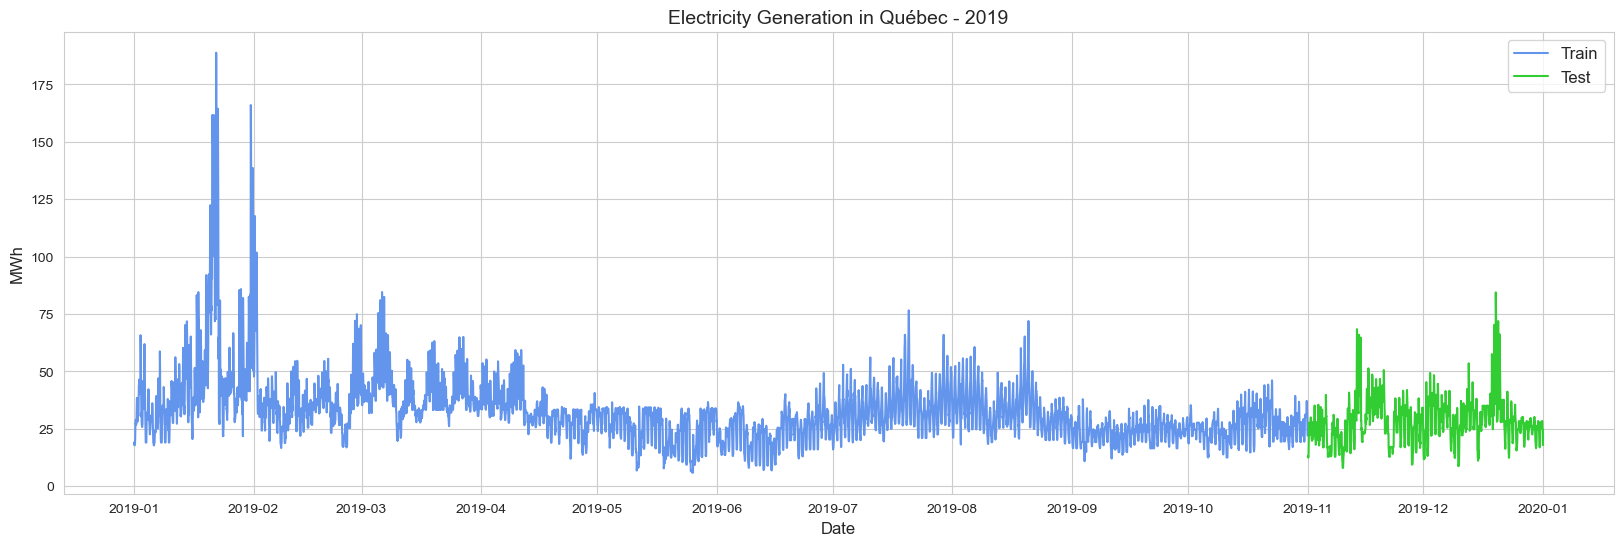

In [566]:
plt.figure(figsize = (20,6))
plt.plot(train, color='cornflowerblue', label='Train')
plt.plot(test, color='limegreen', label='Test')
plt.xlabel('Date', size = 12)
plt.ylabel('MWh', size  = 12)
plt.legend(loc = 'upper right', fontsize="12")
plt.title('Electricity Generation in Québec - 2019', size = 14)

locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)

plt.show()

Outliers? Check with data of 2018 if same effect in January

In [563]:
df2018 = pd.read_excel('/Users/marie-noellepage/Documents/Formation/McGill/2. Applied Artificial Intelligence/4. Time Series Analysis Fundamentals/Course 4/suivi-2018-entente-globale-cadre-1mai2019.xlsx', sheet_name='Feuil1')
df2018.head()

,Month,Day,Hour,MWh
0,1,1,1,63.92
1,1,1,2,64.23
2,1,1,3,54.39
3,1,1,4,53.93
4,1,1,5,57.12


In [565]:
df2018['Year'] = 2018
df2018["Date-Time"] = pd.to_datetime(df2018[['Month', 'Day', 'Year', 'Hour']])
df2018.set_index('Date-Time', inplace=True)
df2018 = df2018.drop(columns=['Month','Day','Hour','Year'])

# Set the timezone format
df2018 = df2018.tz_localize('UTC')

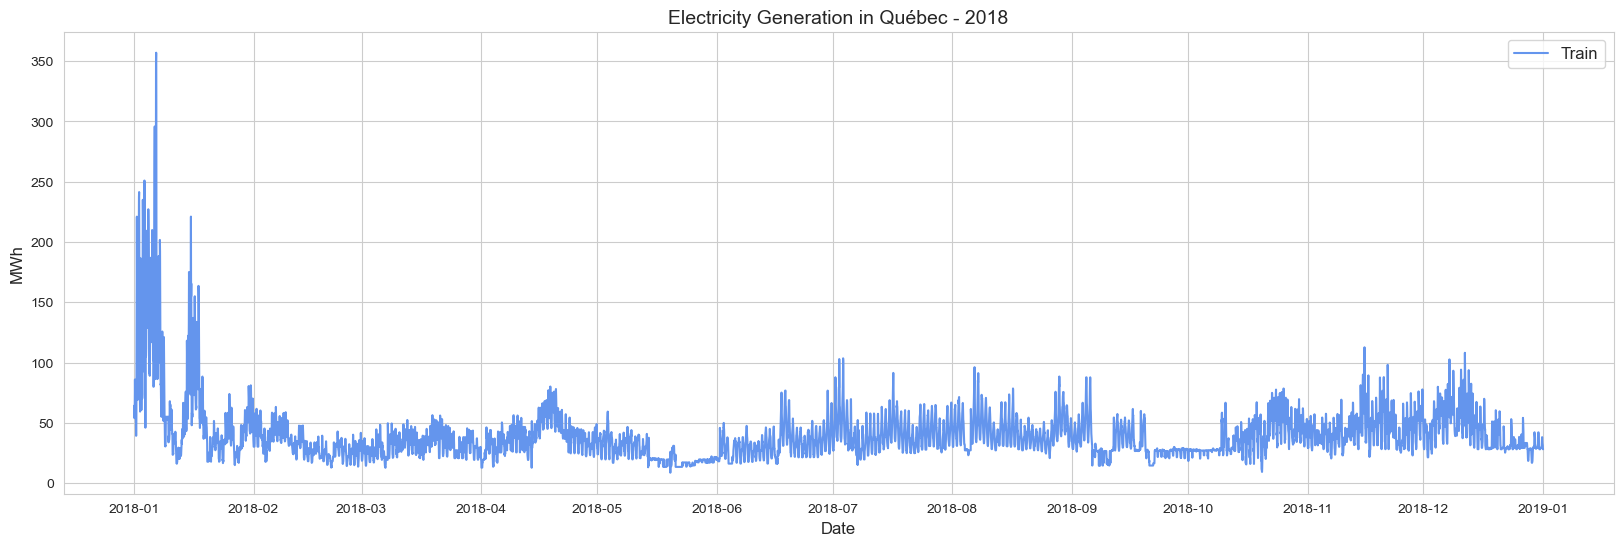

In [567]:
plt.figure(figsize = (20,6))
plt.plot(df2018, color='cornflowerblue', label='Train')
plt.xlabel('Date', size = 12)
plt.ylabel('MWh', size  = 12)
plt.legend(loc = 'upper right', fontsize="12")
plt.title('Electricity Generation in Québec - 2018', size = 14)

locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)

plt.show()

We see the same effect in 2018, which confirms that this is not a problem in the data due to abnormal causes.

The data represents the electricity production, and Hydro-Quebec exports energy to New York. With the cold winter, this may explain the peaks.

Outliers can be subjective. If we want to predict January in future, it might be better to keep this data as it is. That’s why I’ve chosen to keep them.

# Exploration Result for ARIMA Family

There are three trend elements that require configuration.
- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

There are four seasonal elements that are part of SARIMA that must be configured.
- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.

In [570]:
m = dft.resample('M').mean()
v = dft.resample('M').var()

stat = pd.concat([m, v], axis=1).dropna()
stat.index = stat.index.strftime('%m/%Y')
stat.columns = ['Mean','Var']
stat

,Mean,Var
Date-Time,,
01/2019,47.494670,727.267475
02/2019,36.229122,154.625792
03/2019,39.818452,82.025686
04/2019,32.578361,61.349448
05/2019,24.034328,68.069059
06/2019,23.328819,57.355557
07/2019,34.454933,91.925495
08/2019,33.258454,83.507240
09/2019,23.273167,21.917358


We have a small difference in the average for each month (the trend), and high variation.
Let's take a look at November

#### Original Series

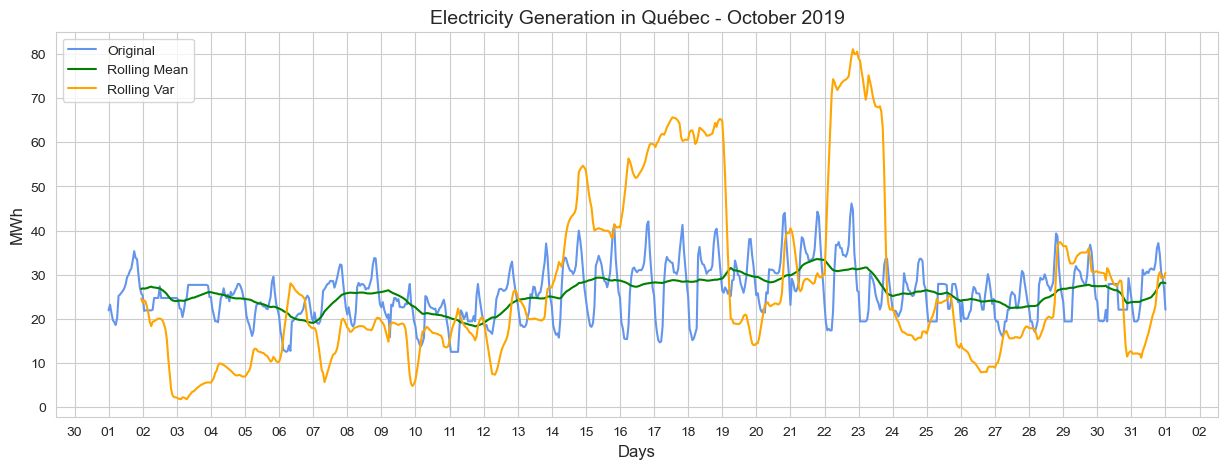

In [576]:
rolling_mean = nov.rolling(window=24).mean()
rolling_var = nov.rolling(window=24).var()

plt.figure(figsize = (15,5))
plt.plot(nov, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_var, color='orange', label='Rolling Var')
plt.xlabel('Days', size = 12)
plt.ylabel('MWh', size  = 12)
plt.title('Electricity Generation in Québec - October 2019', size = 14)
plt.legend(loc = 'upper left')

locator = mdate.DayLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d'))
#plt.gcf().autofmt_xdate()

plt.show()

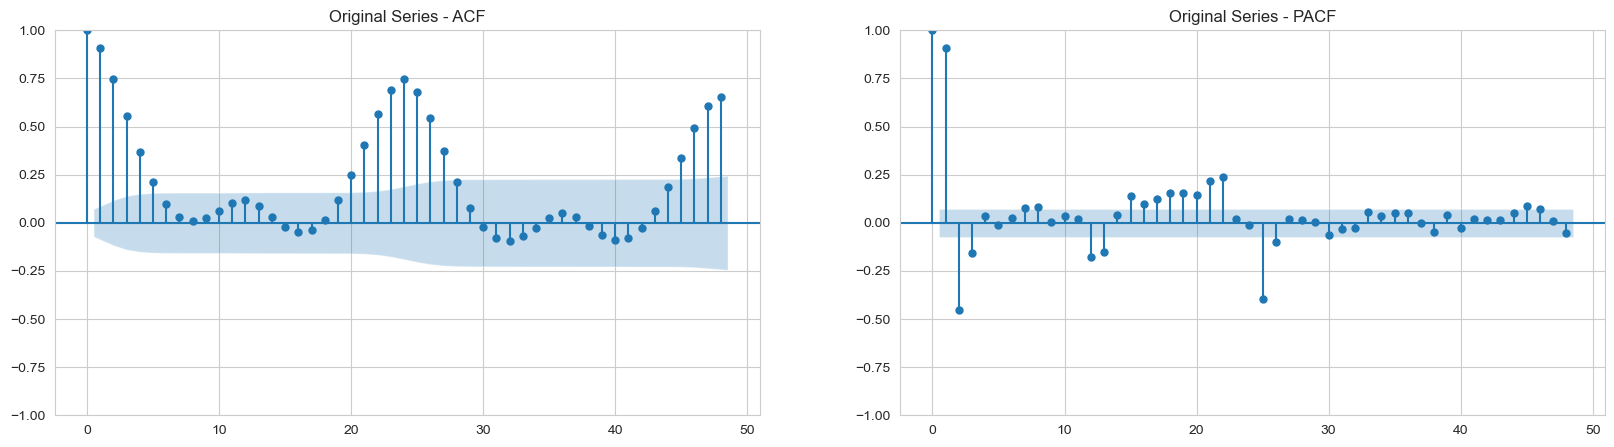

In [656]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(nov, lags=48, title='Original Series - ACF', ax=ax[0])
plot_pacf(nov, lags=48, title='Original Series - PACF', ax=ax[1])
plt.show()

In [577]:
def adfuller_test(ts, window = 24):

    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("----------------------------------")
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("----------------------------------")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")

In [578]:
adfuller_test(nov)

ADF Statistic: -2.057
p-value: 0.262
----------------------------------
Critical Values:
1%: -3.439
5%: -2.866
10%: -2.569
----------------------------------
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


#### 1st Order Differencing --> Trend d = 1

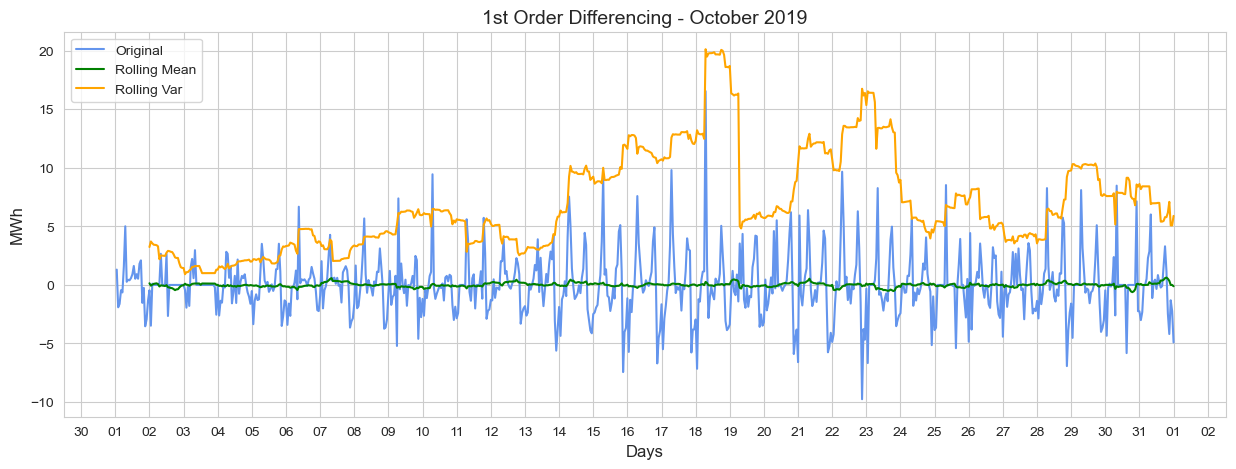

In [579]:
rolling_mean = nov.diff().dropna().rolling(window=24).mean()
rolling_var = nov.diff().dropna().rolling(window=24).var()

plt.figure(figsize = (15,5))
plt.plot(nov.diff().dropna(), color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_var, color='orange', label='Rolling Var')
plt.xlabel('Days', size = 12)
plt.ylabel('MWh', size  = 12)
plt.title('1st Order Differencing - October 2019', size = 14)
plt.legend(loc = 'upper left')

locator = mdate.DayLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d'))
#plt.gcf().autofmt_xdate()

plt.show()

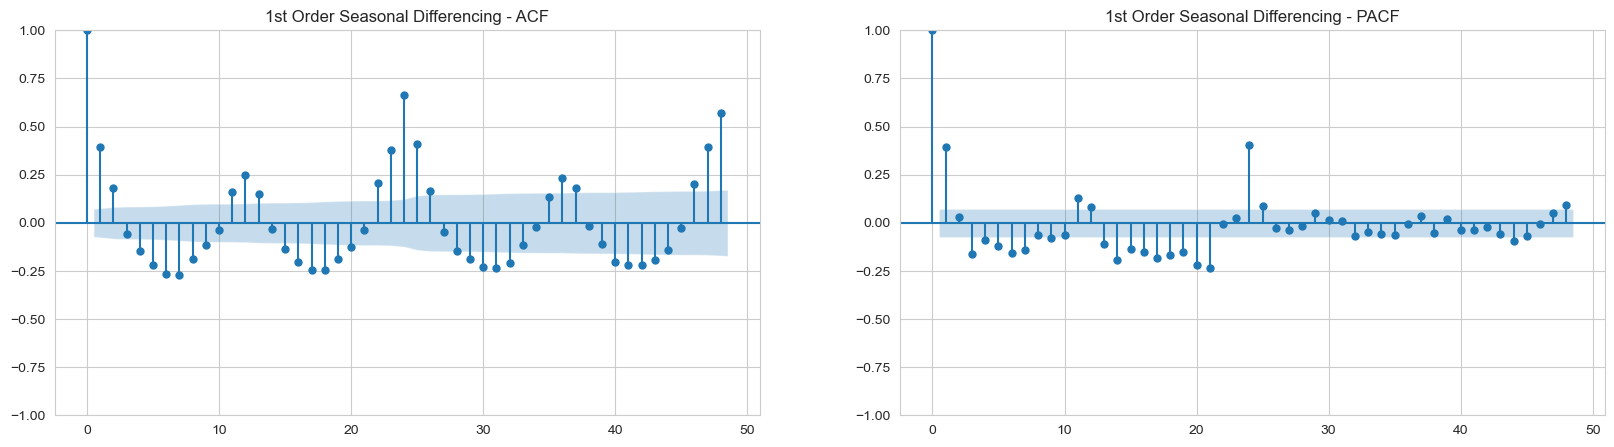

In [655]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(nov.diff().dropna(), lags=48, title='1st Order Seasonal Differencing - ACF', ax=ax[0])
plot_pacf(nov.diff().dropna(), lags=48, title='1st Order Seasonal Differencing - PACF', ax=ax[1])
plt.show()

In [581]:
adfuller_test(nov.diff().dropna())

ADF Statistic: -18.145
p-value: 0.0
----------------------------------
Critical Values:
1%: -3.439
5%: -2.866
10%: -2.569
----------------------------------
ADF < Critical Values
Reject null hypothesis, time series is stationary.


For AR, MA, ARMA and ARIMA:
When I use the first order differentiation, the time series is stationary.
That’s why I chose the parameter d = 1 in the ARIMA family for the trend. From PACF (q = 24) and from ACF (p = 6, 12, 24).

In [582]:
m = dft.resample('M').mean()
v = dft.resample('M').var()
m1 = dft.diff().dropna().resample('M').mean()
v1 = dft.diff().dropna().resample('M').var()

stat = pd.concat([m, v, m1, v1], axis=1).dropna()
stat.index = stat.index.strftime('%m/%Y')
stat.columns = ['Mean','Var','Mean_diff','Var_diff']
stat

,Mean,Var,Mean_diff,Var_diff
Date-Time,,,,
01/2019,47.494670,727.267475,0.044623,111.851760
02/2019,36.229122,154.625792,-0.018631,21.781964
03/2019,39.818452,82.025686,-0.004024,18.798855
04/2019,32.578361,61.349448,-0.008903,9.466900
05/2019,24.034328,68.069059,-0.002742,9.035943
06/2019,23.328819,57.355557,-0.005722,6.060152
07/2019,34.454933,91.925495,0.014758,9.497032
08/2019,33.258454,83.507240,-0.011599,8.505659
09/2019,23.273167,21.917358,-0.004500,5.047438


#### Seasonal Differencing

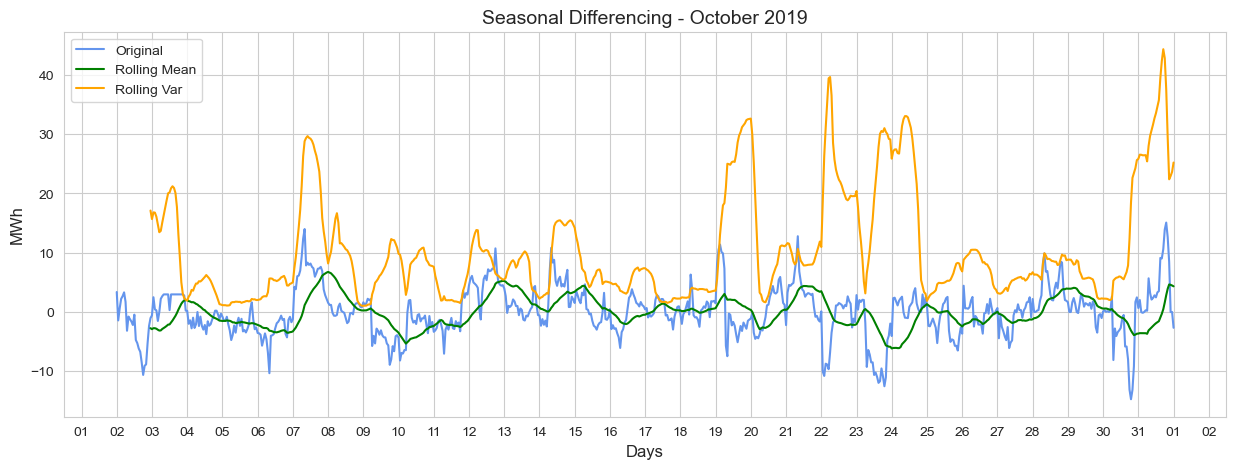

In [676]:
t = nov - nov.shift(24)
rolling_mean = t.rolling(window=24).mean()
rolling_var = t.rolling(window=24).var()

plt.figure(figsize = (15,5))
plt.plot(t.dropna(), color='cornflowerblue',label='Original')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_var, color='orange', label='Rolling Var')
plt.xlabel('Days', size = 12)
plt.ylabel('MWh', size  = 12)
plt.title('Seasonal Differencing - October 2019', size = 14)
plt.legend(loc = 'upper left')

locator = mdate.DayLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d'))
#plt.gcf().autofmt_xdate()

plt.show()

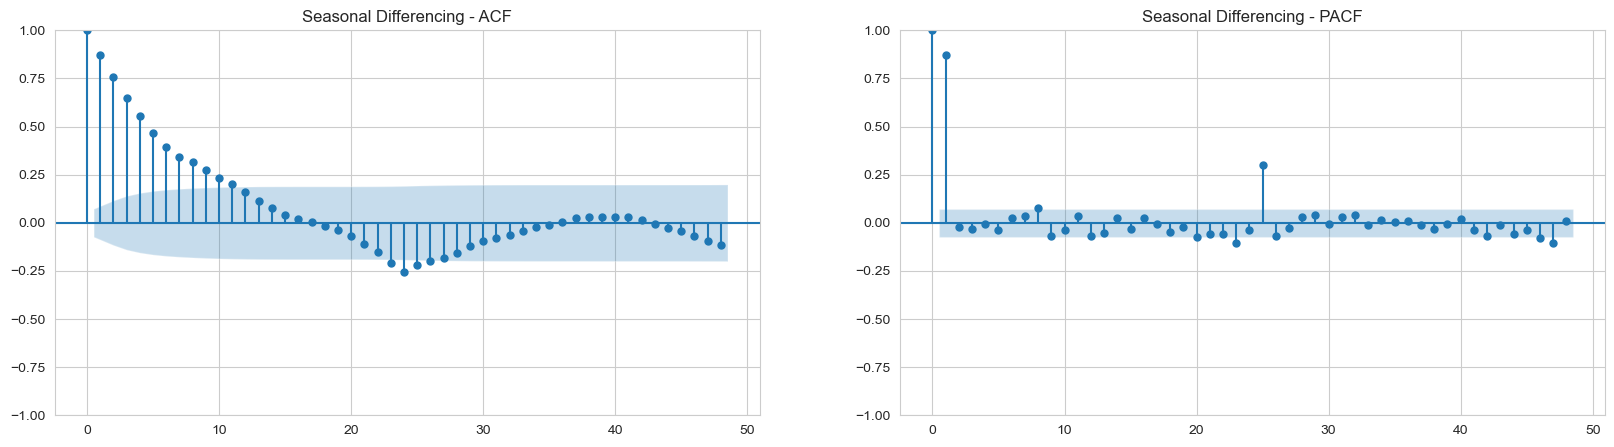

In [677]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(t.dropna(), lags=48, title='Seasonal Differencing - ACF', ax=ax[0])
plot_pacf(t.dropna(), lags=48, title='Seasonal Differencing - PACF', ax=ax[1])
plt.show()

In [589]:
adfuller_test(t.dropna(), window = 24)

ADF Statistic: -6.954
p-value: 0.0
----------------------------------
Critical Values:
1%: -3.439
5%: -2.866
10%: -2.569
----------------------------------
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [591]:
m = dft.resample('M').mean()
v = dft.resample('M').var()
m1 = dft.diff().dropna().resample('M').mean()
v1 = dft.diff().dropna().resample('M').var()
m2 = dft - dft.shift(24).dropna().resample('M').mean()
v2 = dft - dft.shift(24).dropna().resample('M').var()

stat = pd.concat([m, v, m1, v1, m2, v2], axis=1).dropna()
stat.index = stat.index.strftime('%m/%Y')
stat.columns = ['Mean','Var','Mean_diff','Var_diff','Mean_sea','Var_sea']
stat

,Mean,Var,Mean_diff,Var_diff,Mean_sea,Var_sea
Date-Time,,,,,,
01/2019,47.494670,727.267475,0.044623,111.851760,-4.525967,-595.797085
02/2019,36.229122,154.625792,-0.018631,21.781964,4.861533,-260.435057
03/2019,39.818452,82.025686,-0.004024,18.798855,-6.877308,-52.933001
04/2019,32.578361,61.349448,-0.008903,9.466900,-5.470917,-34.300339
05/2019,24.034328,68.069059,-0.002742,9.035943,1.162755,-43.670349
06/2019,23.328819,57.355557,-0.005722,6.060152,2.335639,-33.190670
07/2019,34.454933,91.925495,0.014758,9.497032,-2.992056,-61.572717
08/2019,33.258454,83.507240,-0.011599,8.505659,-7.733508,-58.228848
09/2019,23.273167,21.917358,-0.004500,5.047438,-0.706375,0.308958


#### 1st Order Seasonnal Differencing --> D = 1

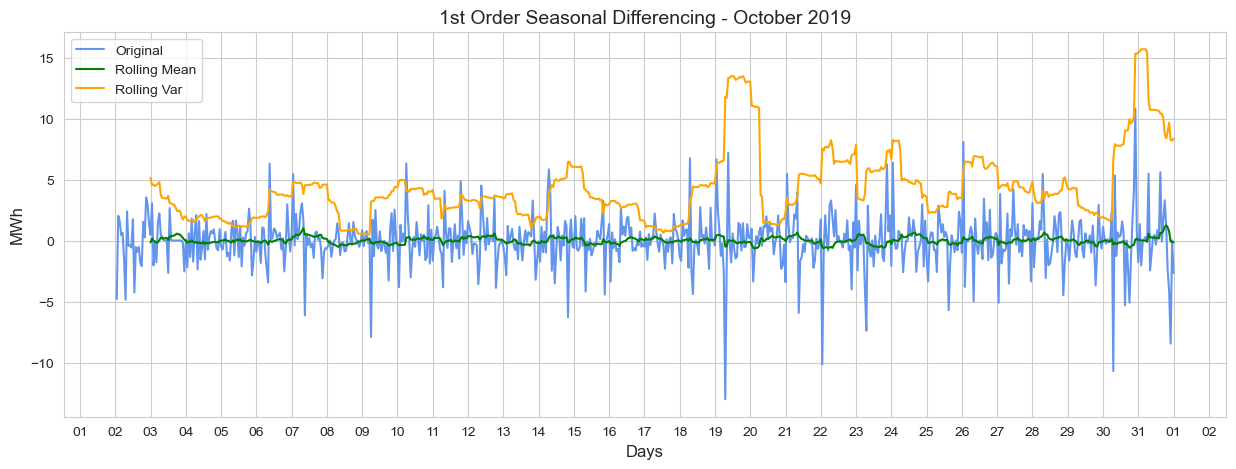

In [678]:
fd = nov.diff().dropna()
t = fd - fd.shift(24)
rolling_mean = t.dropna().rolling(window=24).mean()
rolling_var = t.dropna().rolling(window=24).var()

plt.figure(figsize = (15,5))
plt.plot(t.dropna(), color='cornflowerblue',label='Original')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_var, color='orange', label='Rolling Var')
plt.xlabel('Days', size = 12)
plt.ylabel('MWh', size  = 12)
plt.title('1st Order Seasonal Differencing - October 2019', size = 14)
plt.legend(loc = 'upper left')

locator = mdate.DayLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d'))
#plt.gcf().autofmt_xdate()

plt.show()

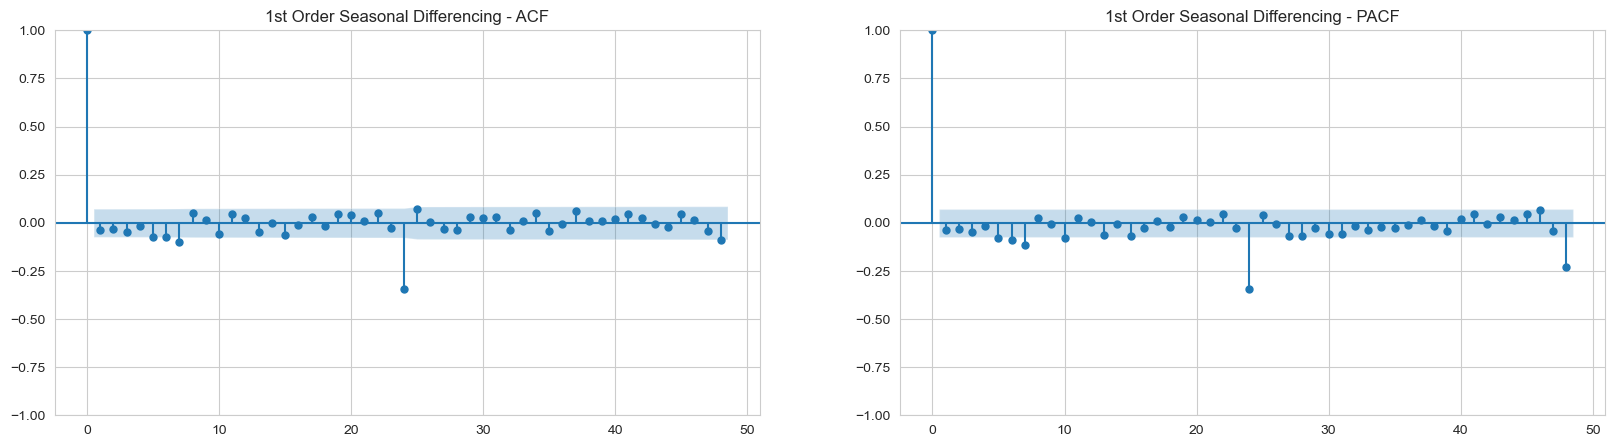

In [679]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(t.dropna(), lags=48, title='1st Order Seasonal Differencing - ACF', ax=ax[0])
plot_pacf(t.dropna(), lags=48, title='1st Order Seasonal Differencing - PACF', ax=ax[1])
plt.show()

SARIMAX:

When I use the first order seasonal differentiation with cycle of 24 hours, the stationarity is better. That’s why I chose the parameter capital D = 1 in the ARIMA family.

The ACF graph for the first order seasonal differentiation allows us the select q parameter. The PACF graph allows us the select p parameter for ARIMA model. We see no strong correlation and I chosen parameter = 0.

Also, we see a decay in the seasonal lags of the PACF and only 1 significant spike at lag 24 in the ACF. I have chosen capital P = 0 and capital Q = 1 for this reason.

In these graphs, we can also see the seasonality of 24 hour (the parameter s).

In [595]:
adfuller_test(t.dropna(), window = 24)

ADF Statistic: -13.347
p-value: 0.0
----------------------------------
Critical Values:
1%: -3.44
5%: -2.866
10%: -2.569
----------------------------------
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [596]:
m = dft.resample('M').mean()
v = dft.resample('M').var()
m1 = dft.diff().dropna().resample('M').mean()
v1 = dft.diff().dropna().resample('M').var()
m2 = dft - dft.shift(24).dropna().resample('M').mean()
v2 = dft - dft.shift(24).dropna().resample('M').var()
m3 = (dft.diff().dropna() - dft.shift(24).diff().dropna()).resample('M').mean()
v3 = (dft.diff().dropna() - dft.shift(24).diff().dropna()).resample('M').var()

stat = pd.concat([m, v, m1, v1, m2, v2, m3, v3], axis=1).dropna()
stat.index = stat.index.strftime('%m/%Y')
stat.columns = ['Mean','Var','Mean_diff','Var_diff','Mean_sea','Var_sea','Mean_sea_diff', 'Var_sea_diff']
stat

,Mean,Var,Mean_diff,Var_diff,Mean_sea,Var_sea,Mean_sea_diff,Var_sea_diff
Date-Time,,,,,,,,
01/2019,47.494670,727.267475,0.044623,111.851760,-4.525967,-595.797085,-0.004889,110.615569
02/2019,36.229122,154.625792,-0.018631,21.781964,4.861533,-260.435057,-0.009226,36.636037
03/2019,39.818452,82.025686,-0.004024,18.798855,-6.877308,-52.933001,-0.003082,13.408180
04/2019,32.578361,61.349448,-0.008903,9.466900,-5.470917,-34.300339,-0.004111,6.666207
05/2019,24.034328,68.069059,-0.002742,9.035943,1.162755,-43.670349,0.000605,10.033178
06/2019,23.328819,57.355557,-0.005722,6.060152,2.335639,-33.190670,-0.001250,5.098604
07/2019,34.454933,91.925495,0.014758,9.497032,-2.992056,-61.572717,0.000753,6.342377
08/2019,33.258454,83.507240,-0.011599,8.505659,-7.733508,-58.228848,-0.001304,6.511292
09/2019,23.273167,21.917358,-0.004500,5.047438,-0.706375,0.308958,0.000528,6.778247


#### How many history to train the ARIMA Family

In literature, I read that a minimum of 50 observations is generally recommended for an ARIMA model. This number is recommended to cover variations and seasonal effects.  At the same time, a good prediction is one that produces appropriate confidence limits (usually around 95%).

For this reason, I have used the autocorrelation graph for one month for the first order differentiation. The blue area represents the 95% confidence interval and is an indicator of the significance level. We can see that after 1 month, all data are close to the blue zone and is statically close to zero.

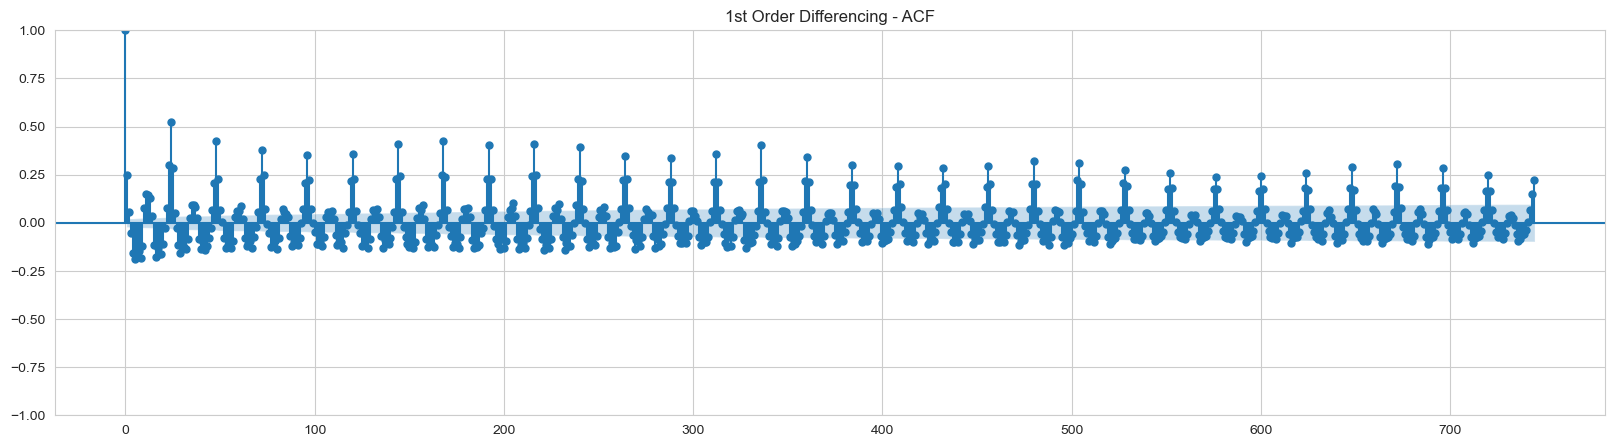

In [607]:
N, M = 12, 6
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(dft.diff().dropna(), lags = 31*24, title='1st Order Differencing - ACF', ax=ax)
plt.show()

# ARIMA Family

### The time Series have a weak trend and seasonality. 
### The most appropriate model for forecasting should be SARIMAX. 

- No Trend & Seasonality: AR(p), MA(q), ARMA(p, q)
- Trend & No Seasonality: ARIMA(p, d, q)
- Trend & Seasonality: SARIMA(p, d, q)(P, D, Q, s)

In [608]:
df1 = train[train.index>='2019-10-01 00:00:00']
print(df1.shape, test.shape)

(745, 1) (1464, 1)


In [609]:
df1.tail()

,MWh
Date-Time,
2019-10-31 20:00:00+00:00,34.72
2019-10-31 21:00:00+00:00,30.53
2019-10-31 22:00:00+00:00,29.22
2019-10-31 23:00:00+00:00,26.99
2019-11-01 00:00:00+00:00,22.08


In [610]:
test.head()

,MWh
Date-Time,
2019-11-01 01:00:00+00:00,13.03
2019-11-01 02:00:00+00:00,12.82
2019-11-01 03:00:00+00:00,12.82
2019-11-01 04:00:00+00:00,12.58
2019-11-01 05:00:00+00:00,12.49


In [611]:
df2 = pd.concat([df1,test])
print(df2.shape)

(2209, 1)


In [612]:
List_Date = df2.loc[(df2.index.get_level_values(0))]
len(List_Date)

2209

In [613]:
Train_Date = df2.loc[(df2.index.get_level_values(0) < '2019-11-01 01:00:00')]
len(Train_Date)

745

In [614]:
# sMAPE
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

### SARIMA model (0, 1, 0) (0, 1, 1, 24)

The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF. For example, an ARIMA(0,0,0)(0,0,1)12 model will show:
- a spike at lag 12 in the ACF but no other significant spikes;
- exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36, …).

Similarly, an ARIMA(0,0,0)(1,0,0)12 model will show:
- exponential decay in the seasonal lags of the ACF;
- a single significant spike at lag 12 in the PACF.

In [675]:
prediction=[]
actual=[]
d=[]
b=0
st = time.time()
    
for i in range(len(Train_Date), len(List_Date)):

    a = df2.index.get_level_values(0)[i]

    trainn = df2.loc[(df2.index.get_level_values(0) < a)]
    testt = df2.loc[(df2.index.get_level_values(0) == a)]

    model = SARIMAX(trainn.tail(len(trainn)-b), order = (0,1,0), seasonal_order=(0,1,1,24))
    model_fitted = model.fit(disp=0)
    preds = model_fitted.forecast(len(testt))
    #print(a, preds.values, testt.values)

    prediction.append(float(preds.values))
    actual.append(float((testt['MWh'].values)))
    d.append(a)
    b = b+1

et = time.time()
elapsed_time = et - st

data = np.array([d,prediction,actual]).T
data1 = pd.DataFrame(data, columns=['date','p','a'])
data1.set_index('date', inplace=True)

smape(data1['a'], data1['p'])

print('sMAPE: ' + str(smape(data1['a'], data1['p'])) + ', time: ' + str(timedelta(seconds=elapsed_time)))

sMAPE: 6.539000359714262, time: 0:22:16.797663


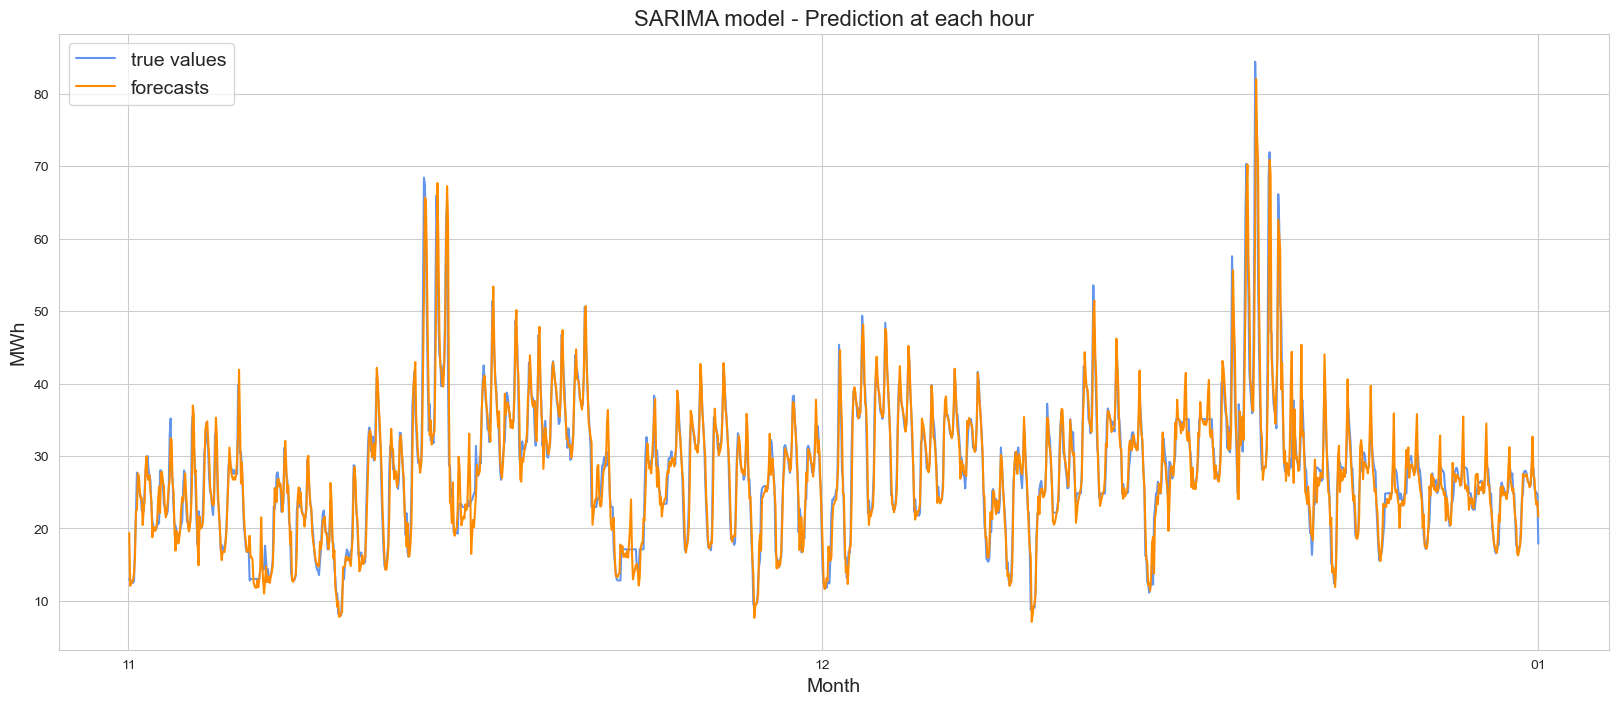

In [680]:
plt.figure(figsize = (20,8))
plt.plot(data1['a'], label = "true values", color = "cornflowerblue")
plt.plot(data1['p'], label = "forecasts", color='darkorange')
plt.xlabel('Month', size = 14)
plt.ylabel('MWh', size  = 14)
plt.title("SARIMA model - Prediction at each hour", size = 16)
plt.legend(loc = 'upper left', fontsize=14)
#plt.gcf().autofmt_xdate()

locator = mdate.MonthLocator()
#loc = mdate.DayLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%m'))
#plt.gca().xaxis.set_minor_locator(loc)
#plt.gca().xaxis.set_minor_formatter(mdate.DateFormatter('%d'))
plt.show()

# Exponential Smoothing: Hold-Winters

For exponential smoothing, I chose Holt-Winters to capture trends and seasonality in the data.

In [721]:
e = ['mul', 'add']
f = ['add', 'mul']

for x, y in itertools.product(e,f):
    
    prediction=[]
    actual=[]
    d=[]
    b=0
    st = time.time()
    
    for i in range(len(Train_Date), len(List_Date)):

        a = df2.index.get_level_values(0)[i]

        trainn_es = df2.loc[(df2.index.get_level_values(0) < a)]
        testt_es = df2.loc[(df2.index.get_level_values(0) == a)]

        model = ExponentialSmoothing(trainn_es.tail(len(trainn_es)-b), trend=x, seasonal=y)
        fit = model.fit()
        preds_optimized = fit.forecast(1)
        #print(a, preds_optimized.values, testt_es.values)

        prediction.append(float(preds_optimized.values))
        actual.append(float((testt_es['MWh'].values)))
        d.append(a)
        b = b+1

    et = time.time()
    elapsed_time = et - st

    data = np.array([d,prediction,actual]).T
    data1 = pd.DataFrame(data, columns=['date','p','a'])
    data1.set_index('date', inplace=True)

    print('trend: ' + str(x) + ', seasonal: '+ str(y) + ', sMAPE: ' + str(smape(data1['a'], data1['p'])) + ', time: ' + str(timedelta(seconds=elapsed_time)))

trend: mul, seasonal: add, sMAPE: 8.096907331814402, time: 0:10:47.366187
trend: mul, seasonal: mul, sMAPE: 6.148885861868973, time: 0:11:09.384637
trend: add, seasonal: add, sMAPE: 6.426638276984134, time: 0:03:25.053000
trend: add, seasonal: mul, sMAPE: 6.129485107575104, time: 0:03:41.016049


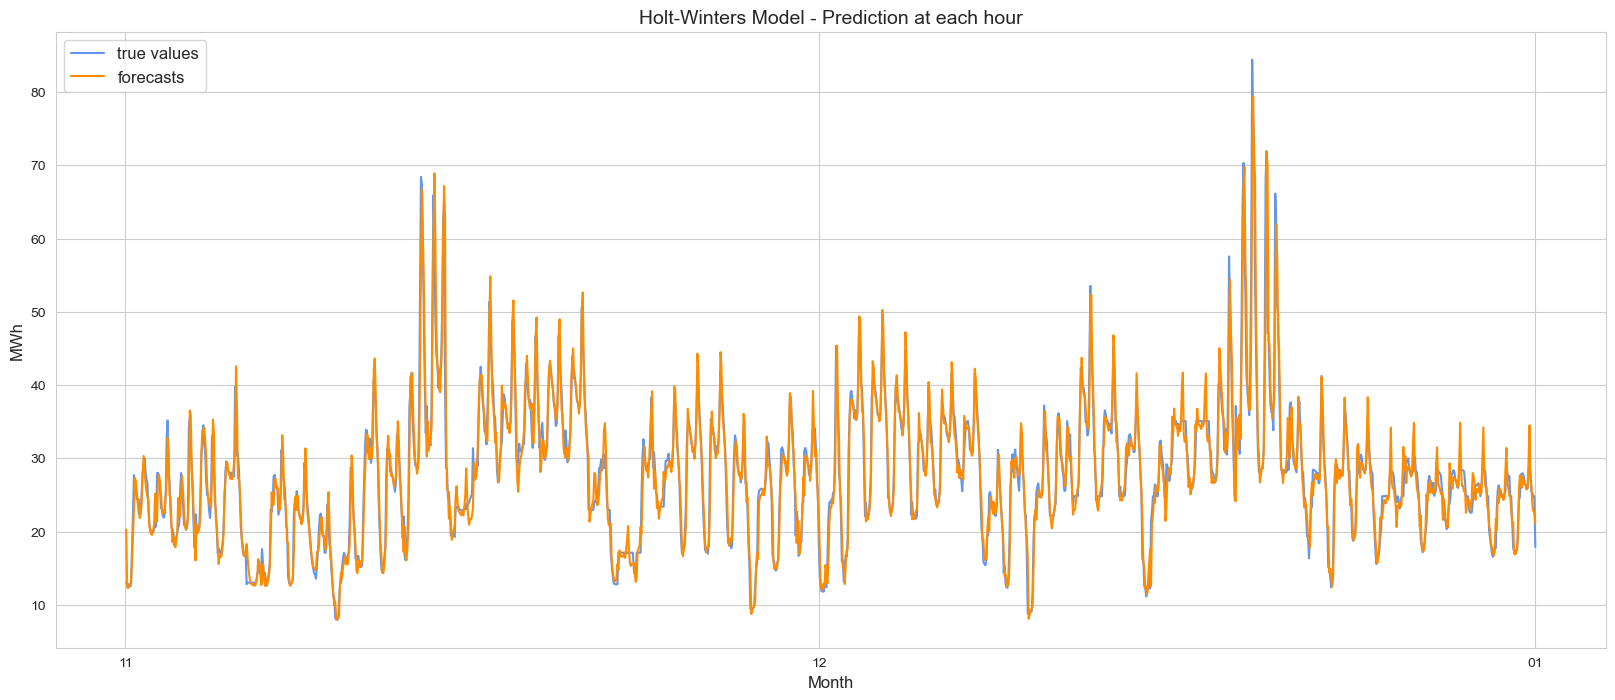

In [722]:
plt.figure(figsize = (20,8))
plt.plot(data2['a'], label = "true values", color = "cornflowerblue")
plt.plot(data2['p'],label = "forecasts", color='darkorange')
plt.xlabel('Month', size = 12)
plt.ylabel('MWh', size  = 12)
plt.title("Holt-Winters Model - Prediction at each hour", size = 14)
plt.legend(loc = 'upper left', fontsize=12)
#plt.gcf().autofmt_xdate()

locator = mdate.MonthLocator()
loc = mdate.DayLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%m'))
#plt.gca().xaxis.set_minor_locator(loc)
#plt.gca().xaxis.set_minor_formatter(mdate.DateFormatter('%d'))
plt.show()

# Machine Learning Based Approach

### Linear Regression

In [732]:
for p in [24, 36, 48, 60, 72, 84]:
    df3 = pd.concat([train,test])
    l = list(range(1, p+1))
    for i in l:
        df3[f'lag_{i}'] = df3['MWh'].shift(i)
    
    h=1
    for i in range(0, h):
        df3[f'out_{i}'] = df3['MWh'].shift(-i)

    df3 = df3.drop('MWh',axis=1)

    train_ml = df3.loc[(df3.index.get_level_values(0) < '2019-11-01 01:00:00')]
    test_ml = df3.loc[(df3.index.get_level_values(0) >= '2019-11-01 01:00:00')]

    train_ml.dropna(axis=0, inplace=True)
    test_ml.dropna(axis=0, inplace=True)

    train_ml_X = train_ml[[x for x in list(train_ml) if 'lag' in x]]
    train_ml_Y = train_ml[[x for x in list(train_ml) if 'out' in x]]
    test_ml_X = test_ml[[x for x in list(test_ml) if 'lag' in x]]
    test_ml_Y = test_ml[[x for x in list(test_ml) if 'out' in x]]
    
    st = time.time()

    lr = LinearRegression()
    lr.fit(train_ml_X, train_ml_Y)
    preds = lr.predict(test_ml_X)

    et = time.time()
    elapsed_time = et - st
    
    print('lags: ' + str(p) + ', sMAPE: ' + str(smape(test_ml_Y.values, preds)) + ', time: ' + str(timedelta(seconds=elapsed_time)))

lags: 24, sMAPE: 7.4153437624496, time: 0:00:00.006950
lags: 36, sMAPE: 6.813454165228262, time: 0:00:00.010775
lags: 48, sMAPE: 6.779831647639019, time: 0:00:00.013609
lags: 60, sMAPE: 6.7150147288678905, time: 0:00:00.014352
lags: 72, sMAPE: 6.687744602186238, time: 0:00:00.017734
lags: 84, sMAPE: 6.787701145584437, time: 0:00:00.022953


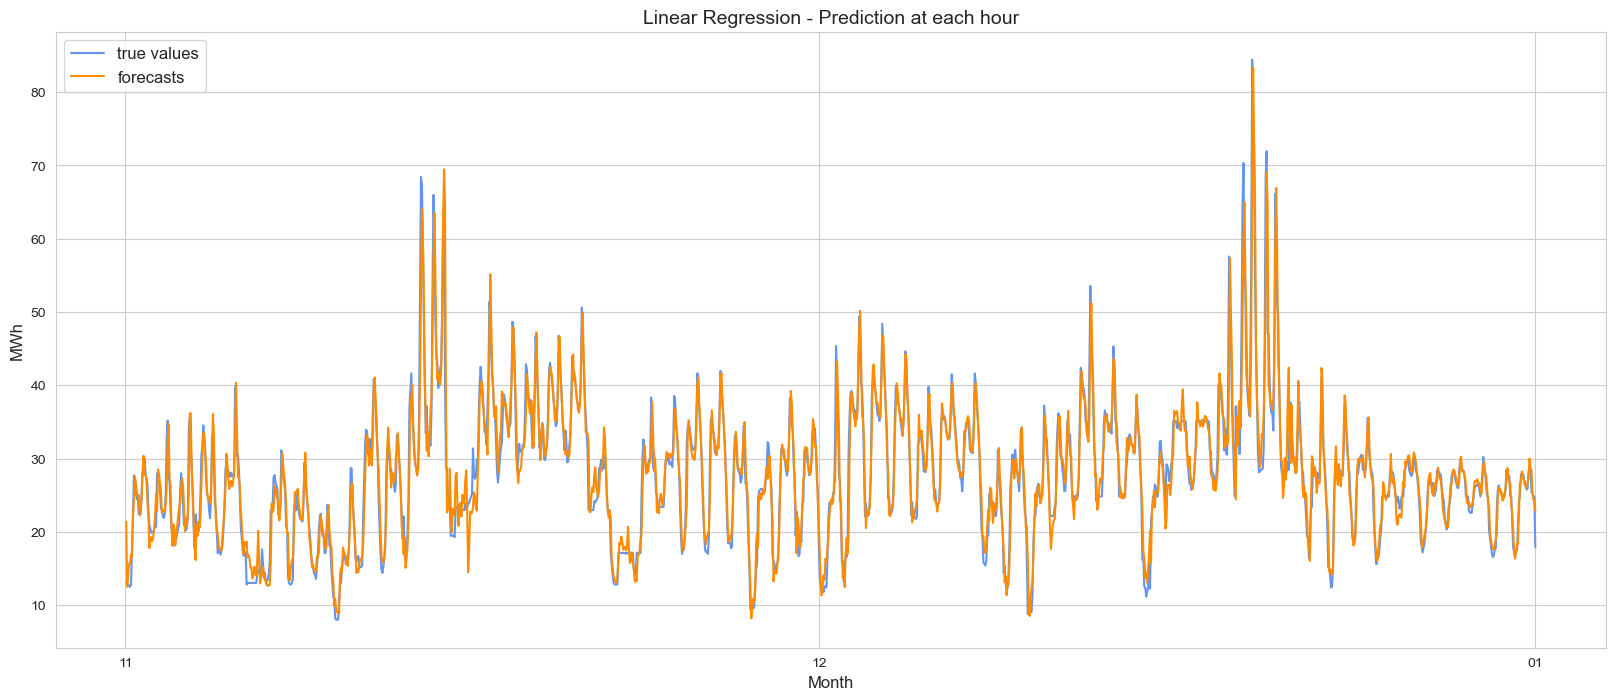

In [725]:
df5['preds'] = lr.predict(test_ml_X)

plt.figure(figsize = (20,8))
plt.plot(df5['out_0'], label = "true values", color = "cornflowerblue")
plt.plot(df5['preds'],label = "forecasts", color='darkorange')
plt.xlabel('Month', size = 12)
plt.ylabel('MWh', size  = 12)
plt.title("Linear Regression - Prediction at each hour", size = 14)
plt.legend(loc = 'upper left', fontsize=12)
#plt.gcf().autofmt_xdate()

locator = mdate.MonthLocator()
loc = mdate.DayLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%m'))
#plt.gca().xaxis.set_minor_locator(loc)
#plt.gca().xaxis.set_minor_formatter(mdate.DateFormatter('%d'))
plt.show()

### Decision Tree Regression

In [734]:
# Test Horizon

for p in [24, 36, 48, 60, 72, 84]:
    df3 = pd.concat([train,test])
    l = list(range(1, p+1))
    for i in l:
        df3[f'lag_{i}'] = df3['MWh'].shift(i)
    
    h=1
    for i in range(0, h):
        df3[f'out_{i}'] = df3['MWh'].shift(-i)

    df3 = df3.drop('MWh',axis=1)

    train_ml = df3.loc[(df3.index.get_level_values(0) < '2019-11-01 01:00:00')]
    test_ml = df3.loc[(df3.index.get_level_values(0) >= '2019-11-01 01:00:00')]

    train_ml.dropna(axis=0, inplace=True)
    test_ml.dropna(axis=0, inplace=True)

    train_ml_X = train_ml[[x for x in list(train_ml) if 'lag' in x]]
    train_ml_Y = train_ml[[x for x in list(train_ml) if 'out' in x]]
    test_ml_X = test_ml[[x for x in list(test_ml) if 'lag' in x]]
    test_ml_Y = test_ml[[x for x in list(test_ml) if 'out' in x]]
    
    st = time.time()

    dt = DecisionTreeRegressor() # max_depth=5
    dt.fit(train_ml_X, train_ml_Y)
    preds = dt.predict(test_ml_X)

    et = time.time()
    elapsed_time = et - st
    
    df4 = test_ml_Y
    df4['preds'] = preds.tolist()
    
    print('lags: ' + str(p) + ', sMAPE: ' + str(smape(df4['out_0'], df4['preds'])) + ', time: ' + str(timedelta(seconds=elapsed_time)))

lags: 24, sMAPE: 9.725072765778682, time: 0:00:00.137297
lags: 36, sMAPE: 10.022830099155577, time: 0:00:00.186650
lags: 48, sMAPE: 9.92846874473013, time: 0:00:00.250914
lags: 60, sMAPE: 9.893592031877802, time: 0:00:00.312744
lags: 72, sMAPE: 10.361941402200012, time: 0:00:00.377009
lags: 84, sMAPE: 10.376252702105132, time: 0:00:00.434711


In [743]:
# For test max_depth

df3 = pd.concat([train,test])

p = 60
l = list(range(1, p+1))
for i in l:
    df3[f'lag_{i}'] = df3['MWh'].shift(i)
    
h=1
for i in range(0, h):
    df3[f'out_{i}'] = df3['MWh'].shift(-i)

df3 = df3.drop('MWh',axis=1)

train_ml = df3.loc[(df3.index.get_level_values(0) < '2019-11-01 01:00:00')]
test_ml = df3.loc[(df3.index.get_level_values(0) >= '2019-11-01 01:00:00')]

train_ml.dropna(axis=0, inplace=True)
test_ml.dropna(axis=0, inplace=True)

train_ml_X = train_ml[[x for x in list(train_ml) if 'lag' in x]]
train_ml_Y = train_ml[[x for x in list(train_ml) if 'out' in x]]
test_ml_X = test_ml[[x for x in list(test_ml) if 'lag' in x]]
test_ml_Y = test_ml[[x for x in list(test_ml) if 'out' in x]]
    
st = time.time()

for i in [3,4,5,6,7]:
    dt = DecisionTreeRegressor(max_depth=i)
    dt.fit(train_ml_X, train_ml_Y)
    preds = dt.predict(test_ml_X)

    et = time.time()
    elapsed_time = et - st
    
    df4 = test_ml_Y
    df4['preds'] = preds.tolist()
    
    print('max_depths: ' + str(i) + ', sMAPE: ' + str(smape(df4['out_0'], df4['preds'])) + ', time: ' + str(timedelta(seconds=elapsed_time)))

max_depths: 3, sMAPE: 10.879313147258106, time: 0:00:00.087913
max_depths: 4, sMAPE: 9.451611917826993, time: 0:00:00.193729
max_depths: 5, sMAPE: 8.522911107035938, time: 0:00:00.321185
max_depths: 6, sMAPE: 8.188374443887314, time: 0:00:00.470460
max_depths: 7, sMAPE: 8.326636509555678, time: 0:00:00.640839


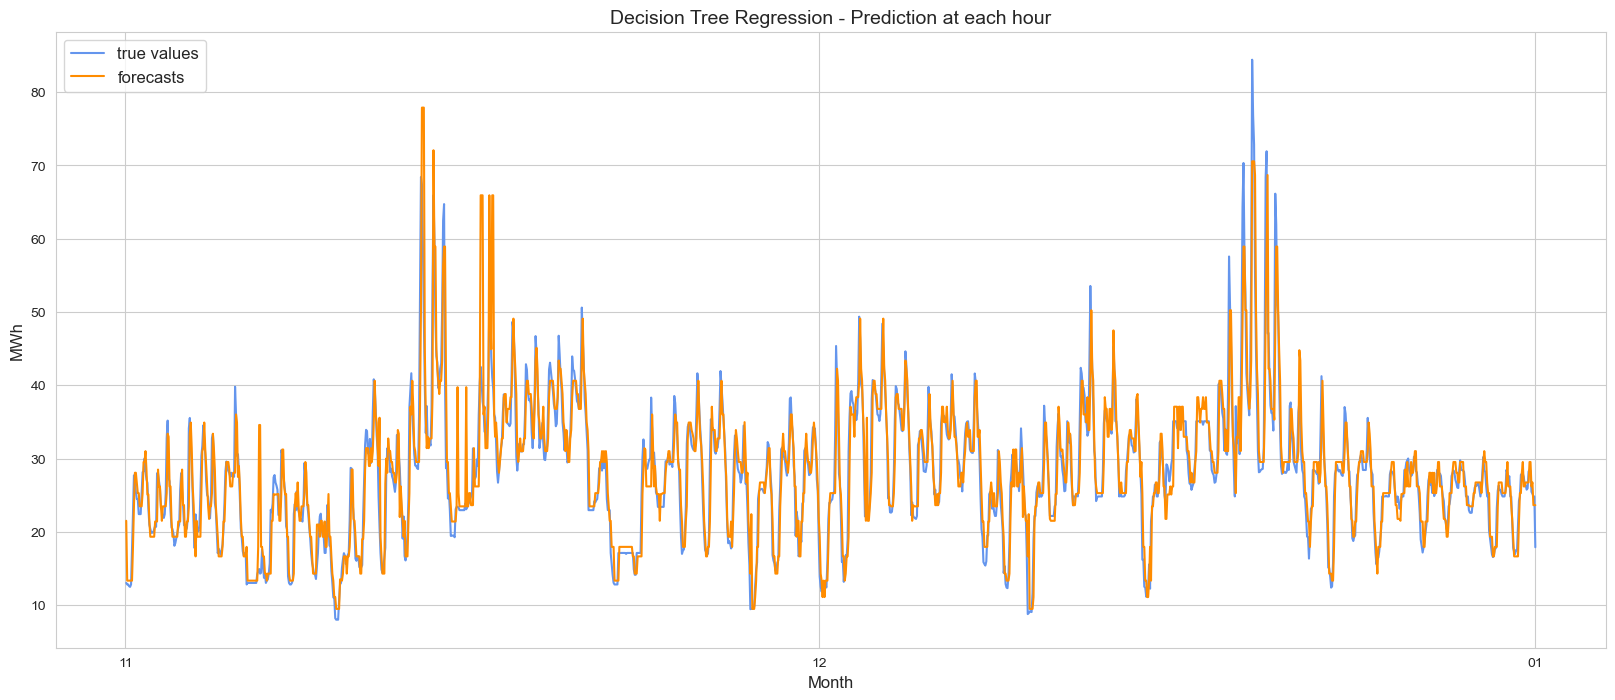

In [747]:
plt.figure(figsize = (20,8))
plt.plot(df4['out_0'], label = "true values", color = "cornflowerblue")
plt.plot(df4['preds'],label = "forecasts", color='darkorange')
plt.xlabel('Month', size = 12)
plt.ylabel('MWh', size  = 12)
plt.title("Decision Tree Regression - Prediction at each hour", size = 14)
plt.legend(loc = 'upper left', fontsize=12)
#plt.gcf().autofmt_xdate()

locator = mdate.MonthLocator()
loc = mdate.DayLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%m'))
#plt.gca().xaxis.set_minor_locator(loc)
#plt.gca().xaxis.set_minor_formatter(mdate.DateFormatter('%d'))
plt.show()

### Support Vector Machine Regresssion

In [749]:
# Test Horizon

for p in [24, 36, 48, 60, 72, 84]:
    df3 = pd.concat([train,test])
    l = list(range(1, p+1))
    for i in l:
        df3[f'lag_{i}'] = df3['MWh'].shift(i)
    
    h=1
    for i in range(0, h):
        df3[f'out_{i}'] = df3['MWh'].shift(-i)

    df3 = df3.drop('MWh',axis=1)

    train_ml = df3.loc[(df3.index.get_level_values(0) < '2019-11-01 01:00:00')]
    test_ml = df3.loc[(df3.index.get_level_values(0) >= '2019-11-01 01:00:00')]

    train_ml.dropna(axis=0, inplace=True)
    test_ml.dropna(axis=0, inplace=True)

    train_ml_X = train_ml[[x for x in list(train_ml) if 'lag' in x]]
    train_ml_Y = train_ml[[x for x in list(train_ml) if 'out' in x]]
    test_ml_X = test_ml[[x for x in list(test_ml) if 'lag' in x]]
    test_ml_Y = test_ml[[x for x in list(test_ml) if 'out' in x]]
    
    st = time.time()

    sv = MultiOutputRegressor(SVR()) #C=50
    sv.fit(train_ml_X, train_ml_Y)
    preds = sv.predict(test_ml_X)

    et = time.time()
    elapsed_time = et - st
    
    print('lags: ' + str(p) + ', sMAPE: ' + str(smape(test_ml_Y.values, preds)) + ', time: ' + str(timedelta(seconds=elapsed_time)))

lags: 24, sMAPE: 7.838602799790652, time: 0:00:01.690069
lags: 36, sMAPE: 7.809681424234749, time: 0:00:02.160979
lags: 48, sMAPE: 8.116759023628711, time: 0:00:02.365207
lags: 60, sMAPE: 8.363838003726917, time: 0:00:02.689192
lags: 72, sMAPE: 8.609130838672508, time: 0:00:02.917158
lags: 84, sMAPE: 8.89894685675783, time: 0:00:03.216280


In [753]:
# For test C

df3 = pd.concat([train,test])

p = 36
l = list(range(1, p+1))
for i in l:
    df3[f'lag_{i}'] = df3['MWh'].shift(i)
    
h=1
for i in range(0, h):
    df3[f'out_{i}'] = df3['MWh'].shift(-i)

df3 = df3.drop('MWh',axis=1)

train_ml = df3.loc[(df3.index.get_level_values(0) < '2019-11-01 01:00:00')]
test_ml = df3.loc[(df3.index.get_level_values(0) >= '2019-11-01 01:00:00')]

train_ml.dropna(axis=0, inplace=True)
test_ml.dropna(axis=0, inplace=True)

train_ml_X = train_ml[[x for x in list(train_ml) if 'lag' in x]]
train_ml_Y = train_ml[[x for x in list(train_ml) if 'out' in x]]
test_ml_X = test_ml[[x for x in list(test_ml) if 'lag' in x]]
test_ml_Y = test_ml[[x for x in list(test_ml) if 'out' in x]]
    
st = time.time()

for i in [0.1,10,50,100]:
    sv = MultiOutputRegressor(SVR(C=i)) #C=50
    sv.fit(train_ml_X, train_ml_Y)
    preds = sv.predict(test_ml_X)

    et = time.time()
    elapsed_time = et - st
    
    print('C: ' + str(i) + ', sMAPE: ' + str(smape(test_ml_Y.values, preds)) + ', time: ' + str(timedelta(seconds=elapsed_time)))

C: 0.1, sMAPE: 11.955554565168338, time: 0:00:02.153579
C: 10, sMAPE: 6.864926580164084, time: 0:00:04.541772
C: 50, sMAPE: 6.841777479333077, time: 0:00:08.347588
C: 100, sMAPE: 6.918729859233179, time: 0:00:13.327331


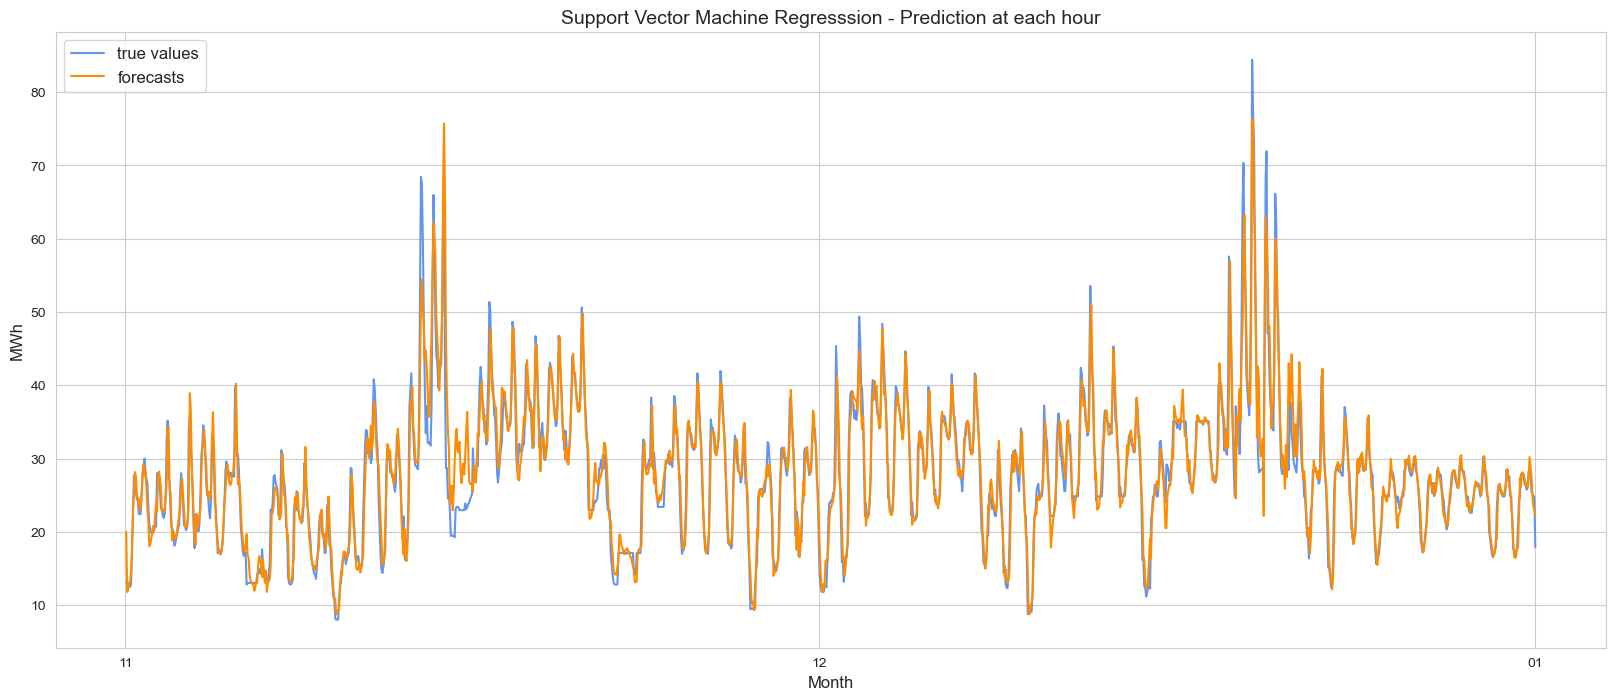

In [755]:
df5['preds'] = sv.predict(test_ml_X)

plt.figure(figsize = (20,8))
plt.plot(test_ml_Y, label = "true values", color = "cornflowerblue")
plt.plot(df5['preds'],label = "forecasts", color='darkorange')
plt.xlabel('Month', size = 12)
plt.ylabel('MWh', size  = 12)
plt.title("Support Vector Machine Regresssion - Prediction at each hour", size = 14)
plt.legend(loc = 'upper left', fontsize=12)
#plt.gcf().autofmt_xdate()

locator = mdate.MonthLocator()
loc = mdate.DayLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%m'))
#plt.gca().xaxis.set_minor_locator(loc)
#plt.gca().xaxis.set_minor_formatter(mdate.DateFormatter('%d'))
plt.show()